In [12]:
library(ggplot2)
library(readr)
library(dplyr)
library(lubridate)


Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date




In [11]:
install.packages("lubridate")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [40]:
deaths <- readr::read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
confirmed <- readr::read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
recovered <- readr::read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.



In [42]:
confirmed %>% head()

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,⋯,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,Thailand,15.0000,101.0000,2,3,5,7,8,8,⋯,70,75,82,114,147,177,212,272,322,411
NA,Japan,36.0000,138.0000,2,1,2,2,4,4,⋯,639,701,773,839,825,878,889,924,963,1007
NA,Singapore,1.2833,103.8333,0,1,3,3,4,5,⋯,178,200,212,226,243,266,313,345,385,432
NA,Nepal,28.1667,84.2500,0,0,0,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
NA,Malaysia,2.5000,112.5000,0,0,0,3,4,4,⋯,149,197,238,428,566,673,790,900,1030,1183
British Columbia,Canada,49.2827,-123.1207,0,0,0,0,0,0,⋯,46,64,64,73,103,103,186,231,271,424


In [3]:
deaths %>% head()

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,⋯,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,Thailand,15.0000,101.0000,0,0,0,0,0,0,⋯,1,1,1,1,1,1,1,1,1,1
NA,Japan,36.0000,138.0000,0,0,0,0,0,0,⋯,16,19,22,22,27,29,29,29,33,35
NA,Singapore,1.2833,103.8333,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2
NA,Nepal,28.1667,84.2500,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
NA,Malaysia,2.5000,112.5000,0,0,0,0,0,0,⋯,0,0,0,0,0,2,2,2,3,4
British Columbia,Canada,49.2827,-123.1207,0,0,0,0,0,0,⋯,1,1,1,1,4,4,7,7,8,10


In [53]:
melter <- function(df, var_name){
    df %>%
    dplyr::select(-Lat, -Long) %>%
rename(region=`Country/Region`, province =`Province/State`) %>%
reshape2::melt(id.vars=c("region", "province")) %>%    
transmute(
    region,
    province,
    ymd=mdy(variable),
    value
) %>%
    rename_(.dots = setNames("value", var_name))
    
    
} 

In [54]:
deaths_df <- melter(deaths, "deaths")
recovered_df <- melter(recovered, "recovered")
confirmed_df <- melter(confirmed, "confirmed")

In [60]:
combined_df <- deaths_df %>%
left_join(recovered_df) %>%
left_join(confirmed_df)

Joining, by = c("region", "province", "ymd")

Joining, by = c("region", "province", "ymd")



In [61]:
combined_df %>% head()

,region,province,ymd,deaths,recovered,confirmed
,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>
1,Thailand,NA,2020-01-22,0,0,2
2,Japan,NA,2020-01-22,0,0,2
3,Singapore,NA,2020-01-22,0,0,0
4,Nepal,NA,2020-01-22,0,0,0
5,Malaysia,NA,2020-01-22,0,0,0
6,Canada,British Columbia,2020-01-22,0,0,0


In [19]:
options(repr.plot.width = 20, repr.plot.height = 8)

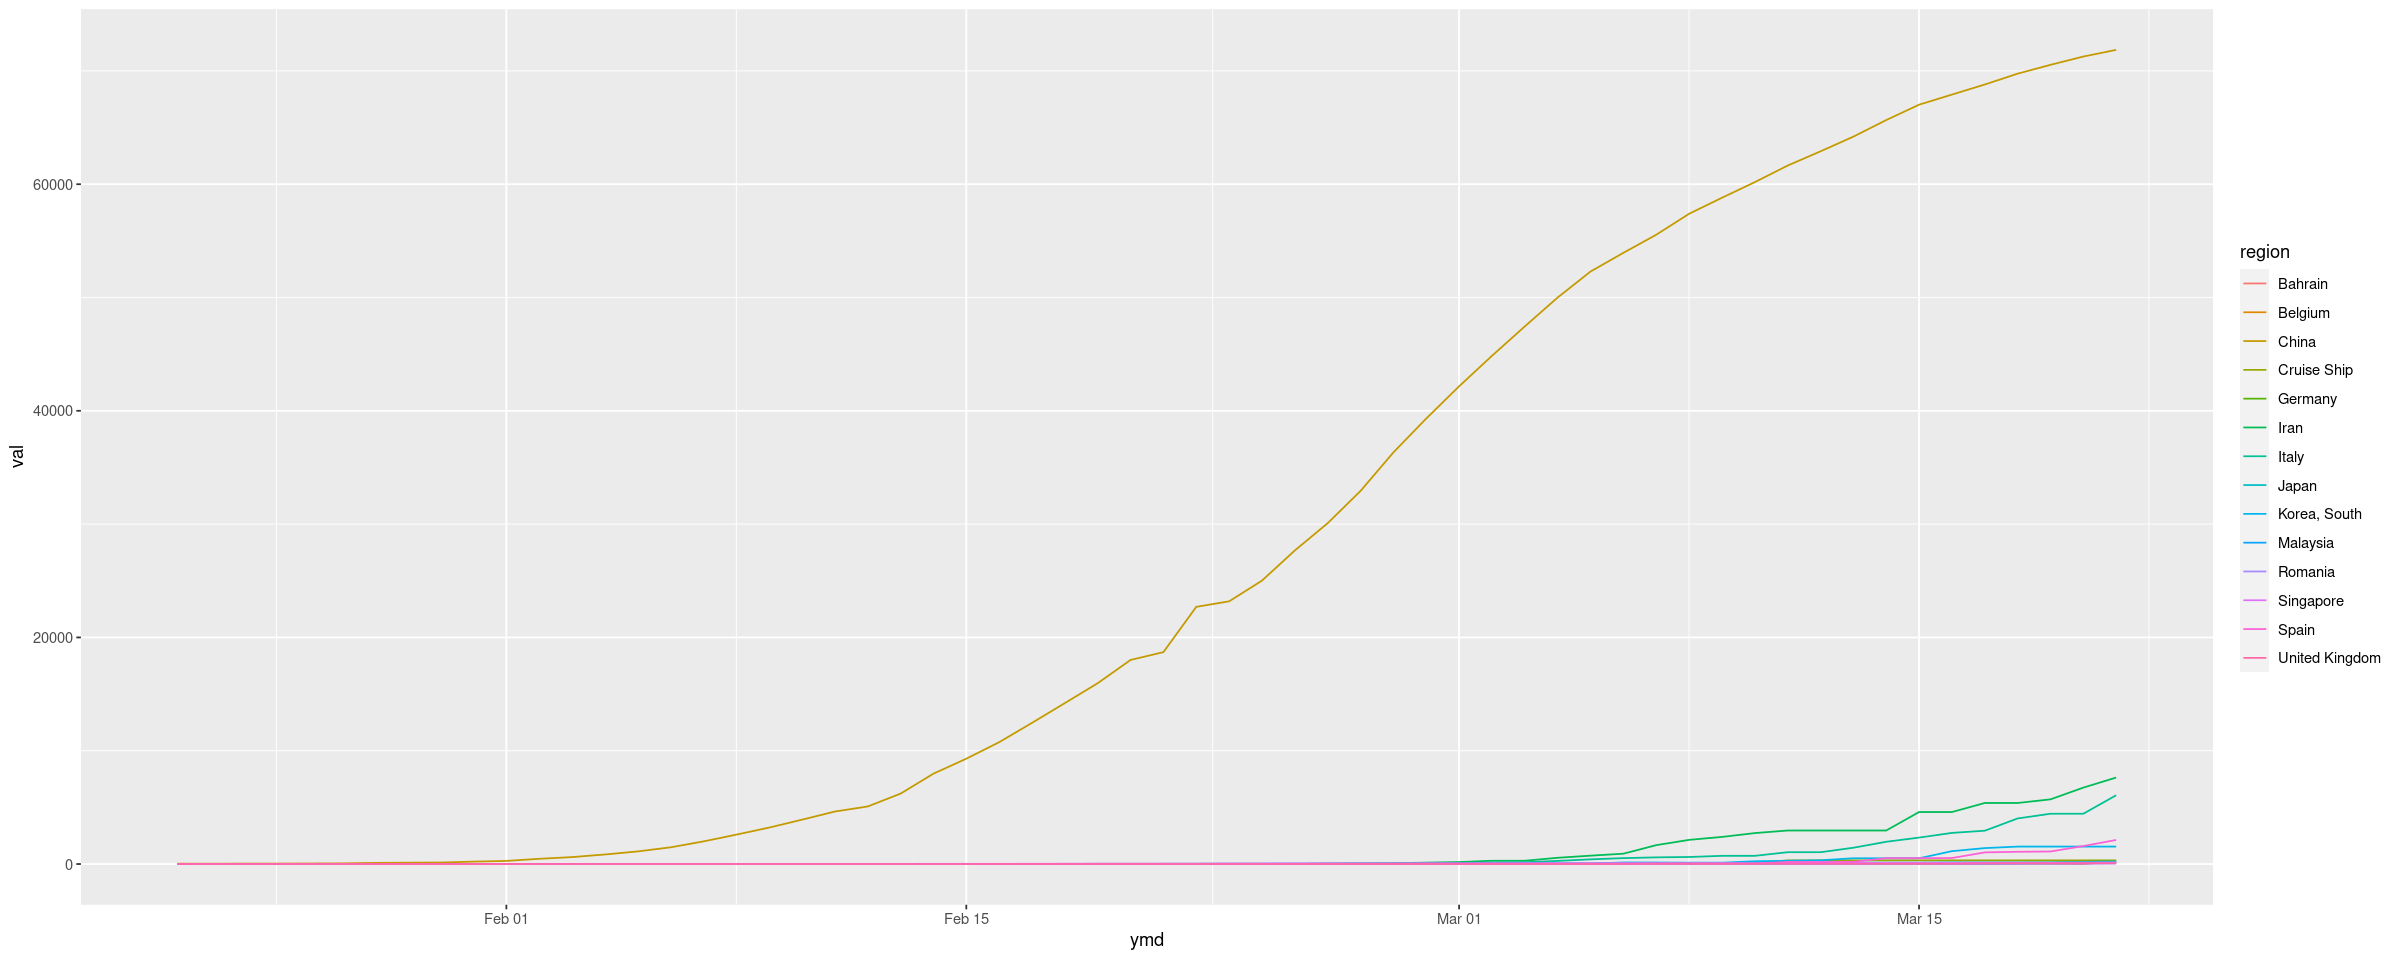

In [65]:
combined_df %>%
group_by(region, ymd) %>%
summarise(
    val = sum(recovered, na.rm = T)
) %>%
group_by(region) %>%
mutate(max_val= max(val)) %>%
ungroup() %>%
arrange(desc(max_val)) %>%
mutate(rank= dense_rank(desc(max_val)))%>%
filter(rank < 15) %>%
ggplot(aes(x=ymd, y= val, color=region)) +
geom_line()